In [1]:
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import csv
from vk4_reader import vk4extract

from scipy.ndimage import gaussian_filter, binary_fill_holes
from skimage import filters, morphology, feature, measure
from scipy.ndimage import binary_dilation, binary_closing
from skimage.morphology import disk
from skimage.measure import label
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import center_of_mass
from numpy.linalg import lstsq

from skimage.feature import blob_log
from skimage.filters import gaussian

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from collections import Counter

from neural_network_stuff import *

%matplotlib widget 

In [2]:
with open('Susan.vk4', 'rb') as in_file:
    offsets = vk4extract.extract_offsets(in_file)
    measurements = vk4extract.extract_measurement_conditions(offsets, in_file)

    rgb_dict = vk4extract.extract_color_data(offsets, 'peak', in_file)
    light_dict = vk4extract.extract_img_data(offsets, 'light', in_file)
    height_dict = vk4extract.extract_img_data(offsets, 'height', in_file)

rgb_data = rgb_dict['data']
light_data = light_dict['data']
height_data = height_dict['data']

x_shape = light_dict['width']
y_shape = light_dict['height']

# scale
x_scale = measurements['x_length_per_pixel'] * 1e-6 # um
y_scale = measurements['y_length_per_pixel'] * 1e-6 # um
z_scale = measurements['z_length_per_digit'] * 1e-6 # um

# reshape
rgb_array = np.reshape(rgb_data, (y_shape, x_shape, 3))
light_array = np.reshape(light_data, (y_shape, x_shape))
height_array = np.reshape(height_data, (y_shape, x_shape)) * z_scale

# normalize
light_array = light_array - np.min(light_array)
light_array = light_array / np.max(light_array)


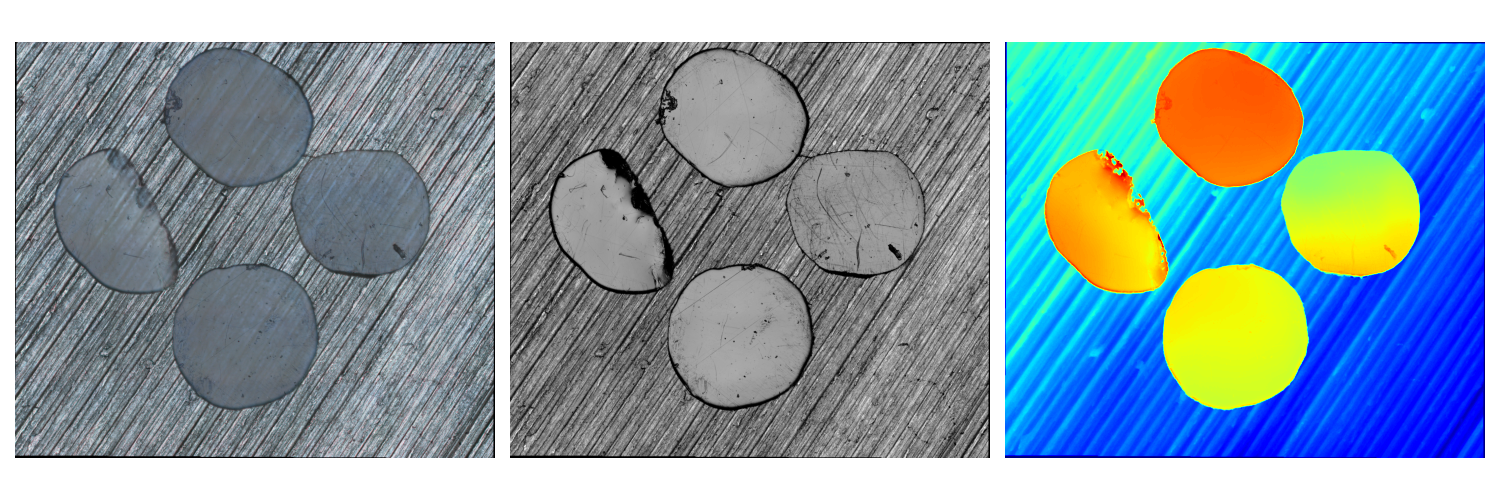

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax[0].imshow(rgb_array)
ax[1].imshow(light_array, cmap = 'gray')
ax[2].imshow(height_array, cmap = 'jet')

for a in ax:
    a.axis('off')
fig.tight_layout()  


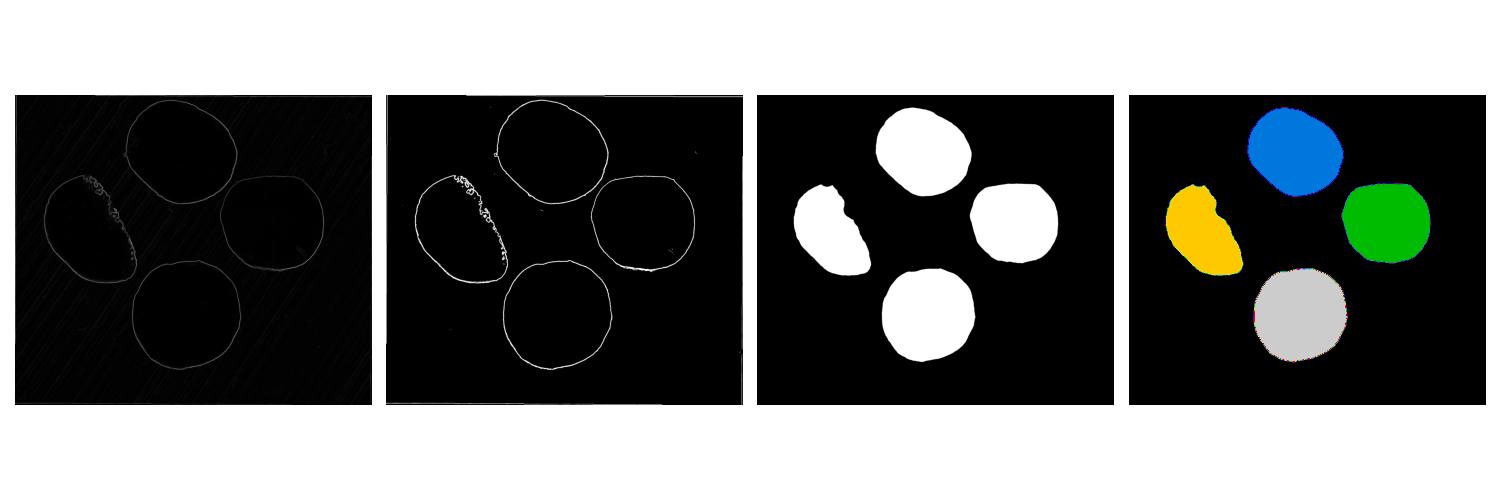

In [4]:
smoothed = gaussian_filter(height_array, sigma=2)
edges = filters.sobel(smoothed)
edges = edges - np.min(edges)
edges = edges / np.max(edges)

threshold = 0.1 # between 0 and 1
binary_edges = edges > threshold

# Fill holes and clean small objects
connected_edges = binary_closing(binary_edges, structure=disk(5))
filled_edges = binary_fill_holes(connected_edges)
cleaned_mask = morphology.remove_small_objects(filled_edges, min_size=500)
# erode regions
distance = distance_transform_edt(cleaned_mask)
erosion_depth = 100  # Number of pixels to erode
eroded_mask = distance > erosion_depth

labeled_mask = label(eroded_mask)

fig, ax = plt.subplots(1,4, figsize=(15,5), sharex=True, sharey=True)
ax[0].imshow(edges, cmap='gray')
ax[1].imshow(binary_edges, cmap='gray')
ax[2].imshow(eroded_mask, cmap='gray')
ax[3].imshow(labeled_mask, cmap='nipy_spectral')
for a in ax:
    a.axis('off')
fig.tight_layout()

Text(0.5, 1.0, 'Flattened Height Array')

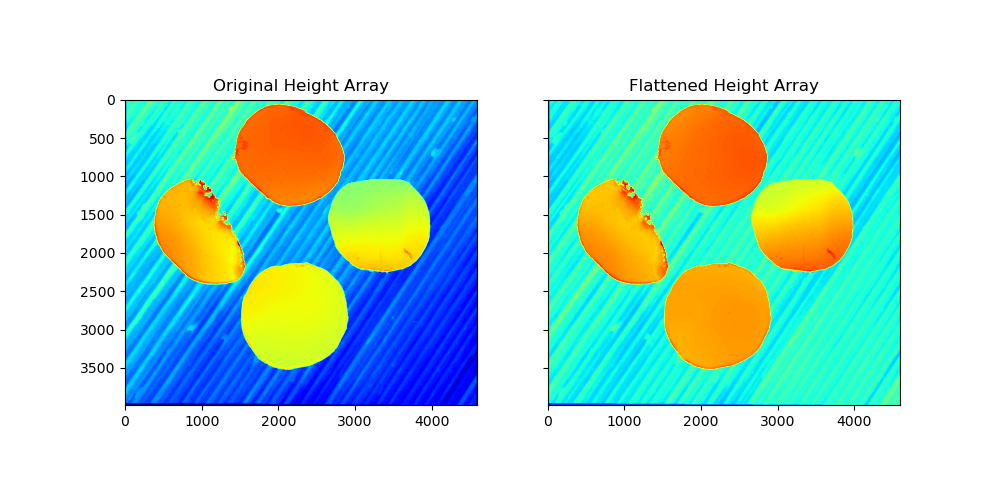

In [5]:
#let's fit a plane to the background of the height array and subtract it
background_mask = 1 - cleaned_mask.astype(np.uint8)
height_background = np.ma.masked_where(background_mask == 0, height_array)

# Fit a plane to the background
x, y = np.meshgrid(np.arange(height_array.shape[1]), np.arange(height_array.shape[0]))
x = x[background_mask == 1]
y = y[background_mask == 1]
z = height_array[background_mask == 1]
A = np.c_[x, y, np.ones_like(x)]
coeffs, _, _, _ = lstsq(A, z, rcond=None)  # Solve for [a, b, c]
plane = coeffs[0] * np.arange(height_array.shape[1])[None, :] + \
        coeffs[1] * np.arange(height_array.shape[0])[:, None] + \
        coeffs[2]
flattened_height = height_array - plane

fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax[0].imshow(height_array, cmap='jet')
ax[0].set_title('Original Height Array')
ax[1].imshow(flattened_height, cmap='jet')
ax[1].set_title('Flattened Height Array')


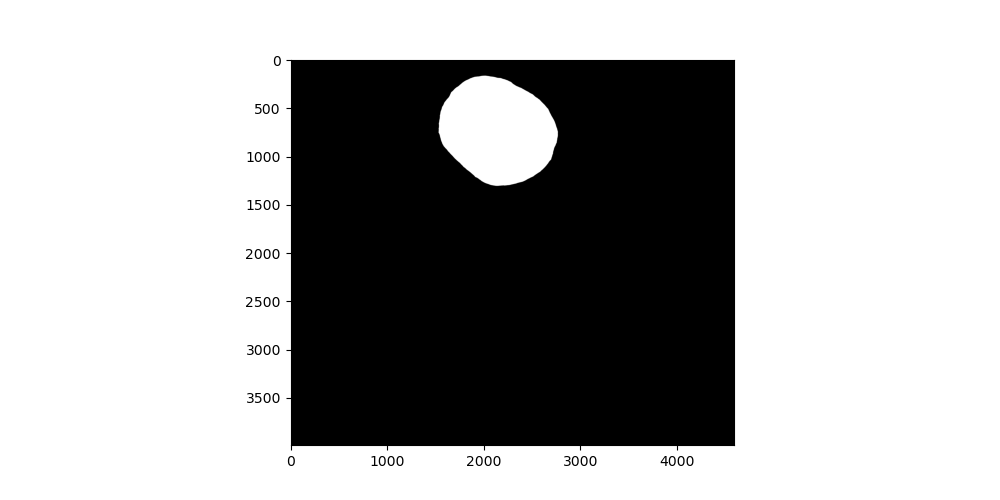

In [6]:
# let's start in label 1
labeler = 1

region_of_interest = np.where(labeled_mask == labeler, 1, 0)

fig, ax = plt.subplots(1,1, figsize=(10,5), sharex=True, sharey=True)
ax.imshow(region_of_interest, cmap='gray')

(-0.5, 1235.5, 1140.5, -0.5)

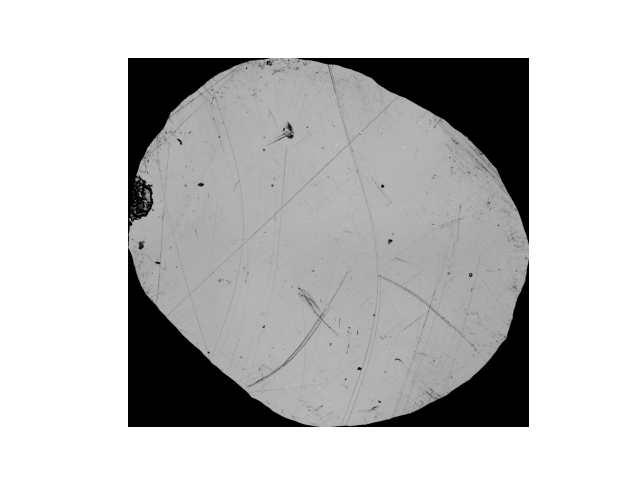

In [7]:
selected_area = light_array * region_of_interest
roi_bounding_box = [np.min(np.where(region_of_interest)[0]), np.max(np.where(region_of_interest)[0]), np.min(np.where(region_of_interest)[1]), np.max(np.where(region_of_interest)[1])]
roi = selected_area[roi_bounding_box[0]:roi_bounding_box[1], roi_bounding_box[2]:roi_bounding_box[3]]
roi_rgb = rgb_array[roi_bounding_box[0]:roi_bounding_box[1], roi_bounding_box[2]:roi_bounding_box[3]]

plt.figure()
plt.imshow(roi, cmap = 'gray')
plt.axis('off')

In [8]:
# # save array as an image
# import PIL
# from PIL import Image
# 
# im = Image.fromarray((roi * 255).astype(np.uint8))
# im.save('roi.png')

(-0.5, 1235.5, 1140.5, -0.5)

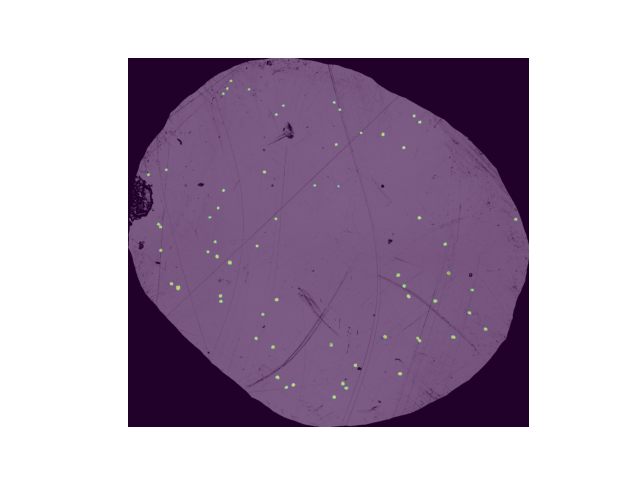

In [9]:
# hand labeled datasets:
path = './labelled_datasets/'
files = os.listdir(path)
label_mask = np.zeros_like(roi)
for file in files:
    data = np.load(os.path.join(path, file))
    label_mask += data 
label_mask[label_mask > 0] = 1

plt.figure()
plt.imshow(roi, cmap = 'gray')
plt.imshow(label_mask, alpha = 0.5)
plt.axis('off')

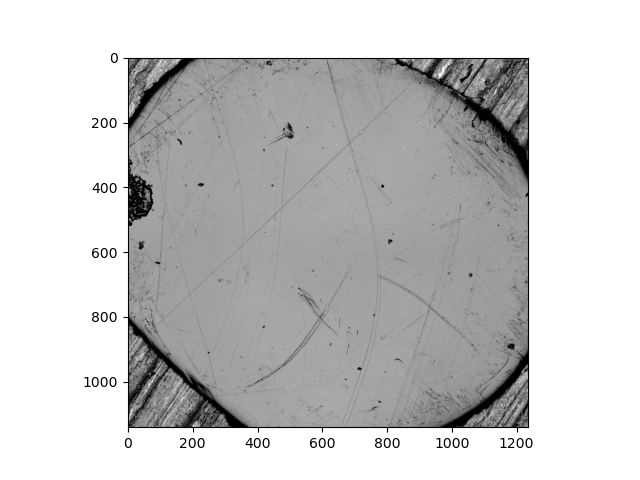

In [10]:
cropped_image = light_array[roi_bounding_box[0]:roi_bounding_box[1], roi_bounding_box[2]:roi_bounding_box[3]]

plt.figure()
plt.imshow(cropped_image, cmap = 'gray')

In [11]:
from neural_network_stuff import *

In [12]:
# Create dataset and dataloader
patch_size = (40, 40)
dataset = SegmentationDataset(cropped_image, label_mask, patch_size=patch_size)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

for image_batch, label_batch in dataloader:
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break

class_weights = compute_class_weights(label_mask)
print("Computed class weights:", class_weights)


# Check if a GPU is available and if not, use a CPU
if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps') # backend for Apple silicon GPUs
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)


# Finally, let's train the model
model = Unet(input_channels=1, num_classes=2,
    num_filters=[16,32,64], dropout = 0.1).to(device)

num_trainable_params = count_trainable_parameters(model)
print('\n')
print(f"Number of trainable parameters: {num_trainable_params}")

# Training setup
class_weights_tensor = torch.tensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 30

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")
print("Training finished.")


Image batch shape: torch.Size([16, 1, 40, 40])
Label batch shape: torch.Size([16, 40, 40])
Computed class weights: [0.0036872215084139555, 0.996312778491586]
mps


Number of trainable parameters: 117410
Epoch 1/30, Loss: 0.6470
Epoch 2/30, Loss: 0.5820
Epoch 3/30, Loss: 0.4804
Epoch 4/30, Loss: 0.3979
Epoch 5/30, Loss: 0.3564
Epoch 6/30, Loss: 0.3417
Epoch 7/30, Loss: 0.2937
Epoch 8/30, Loss: 0.2775
Epoch 9/30, Loss: 0.2400
Epoch 10/30, Loss: 0.2378
Epoch 11/30, Loss: 0.2155
Epoch 12/30, Loss: 0.2107
Epoch 13/30, Loss: 0.1725
Epoch 14/30, Loss: 0.1805
Epoch 15/30, Loss: 0.1590
Epoch 16/30, Loss: 0.1614
Epoch 17/30, Loss: 0.1654
Epoch 18/30, Loss: 0.1548
Epoch 19/30, Loss: 0.1488
Epoch 20/30, Loss: 0.1529
Epoch 21/30, Loss: 0.1272
Epoch 22/30, Loss: 0.1870
Epoch 23/30, Loss: 0.1284
Epoch 24/30, Loss: 0.1213
Epoch 25/30, Loss: 0.1109
Epoch 26/30, Loss: 0.0960
Epoch 27/30, Loss: 0.0920
Epoch 28/30, Loss: 0.0880
Epoch 29/30, Loss: 0.0865
Epoch 30/30, Loss: 0.0808
Training finished.


In [13]:
# save the network to load in a different notebook:
torch.save(model.state_dict(), 'unet_model.pth')


### older code below:

In [ ]:
# Create dataset and dataloader
patch_size = (40, 40)
dataset = SegmentationDataset(cropped_image, label_mask, patch_size=patch_size)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

for image_batch, label_batch in dataloader:
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break

class_weights = compute_class_weights(label_mask)
print("Computed class weights:", class_weights)



# Finally, let's train the model
model = Unet(input_channels=1, num_classes=2,
    num_filters=[16,32,64], dropout = 0.1).to(device)

num_trainable_params = count_trainable_parameters(model)
print('\n')
print(f"Number of trainable parameters: {num_trainable_params}")

# Training setup
class_weights_tensor = torch.tensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 30

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}")
print("Training finished.")


In [ ]:
def predict(model, image_patch, device):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(image_patch.to(device))  # Forward pass
        prediction = torch.sigmoid(output).cpu().squeeze(0).squeeze(0)  # Convert to 1xHxW
    return prediction

def predict_full_image(model, device, image, patch_size=40, stride=20, edge_crop=3):
    model.eval()
    height, width = image.shape
    prediction = np.zeros((height, width))
    counts = np.zeros((height, width))  # To keep track of overlapping predictions for averaging
    
    with torch.no_grad():
        for y in range(0, height - patch_size + 1, stride):
            for x in range(0, width - patch_size + 1, stride):
                # Extract patch
                patch = image[y:y + patch_size, x:x + patch_size]
                patch = torch.from_numpy(patch).float().unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions
                
                # Predict
                pred = torch.sigmoid(model(patch)).cpu().squeeze(0).squeeze(0).numpy()[1]
                pred = pred[edge_crop:-edge_crop, edge_crop:-edge_crop]
                # Accumulate prediction
                prediction[y+edge_crop:y + patch_size-edge_crop, x+edge_crop:x + patch_size-edge_crop] += pred
                counts[y+edge_crop:y + patch_size-edge_crop, x+edge_crop:x + patch_size-edge_crop] += 1
    
    # Avoid division by zero and normalize by the number of overlapping patches
    prediction /= np.maximum(counts, 1)
    return prediction

In [ ]:
# # make a random 40, 40 patch
# 
# # get a random number from 
# xlim = roi.shape[1]
# ylim = roi.shape[0]
# x = np.random.randint(20, xlim-20)
# y = np.random.randint(20, ylim-20)
# 
# x = 274
# y = 613
# 
# # get the patch
# patch = roi[y-20:y+20, x-20:x+20]
# patch = torch.from_numpy(patch).float().unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
# 
# # predict
# pred = predict(model, patch, device=device).numpy()
# 
# fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
# 
# ax[0].imshow(patch.squeeze(0).squeeze(0), cmap = 'gray')
# ax[1].imshow(pred[1], cmap = 'jet')